## Download Coco-Stuff initial version

Homepage: https://github.com/nightrome/cocostuff10k

In [1]:
!wget -q http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/cocostuff-10k-v1.1.zip
!unzip -q cocostuff-10k-v1.1.zip -d dataset

## Imports

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.io import loadmat
import numpy as np
import glob
import os

## Constants

In [3]:
PATH = "dataset"
SPLIT = 0.1
BATCH_SIZE = 16
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 172  # https://github.com/nightrome/cocostuff10k#label-names--indices
# Should this be 183?

## Load training and test filenames

In [4]:
train_names = np.loadtxt(f"{PATH}/imageLists/train.txt", dtype=str)
np.random.shuffle(train_names)

test_names = np.loadtxt(f"{PATH}/imageLists/test.txt", dtype=str)

## Utility for creating dataset paths

In [5]:
def get_dataset_paths(filenames):
    image_filepaths = [f"{PATH}/images/{filename}.jpg" for filename in filenames]
    annotation_filepaths = [
        f"{PATH}/annotations/{filename}.mat" for filename in filenames
    ]
    return image_filepaths, annotation_filepaths

## Create train/val/test sets

In [13]:
train_image_paths, train_anno_paths = get_dataset_paths(train_names)
split_index = int(len(train_image_paths) * (1 - SPLIT))
new_train_image_paths = train_image_paths[:split_index]
new_train_anno_paths = train_anno_paths[:split_index]

val_image_paths = train_image_paths[split_index:]
val_anno_paths = train_anno_paths[split_index:]

test_image_paths, test_anno_paths = get_dataset_paths(test_names)

print(f"Total training samples: {len(new_train_image_paths)}.")
print(f"Total validation samples: {len(val_image_paths)}.")
print(f"Total test samples: {len(test_image_paths)}.")

Total training samples: 8100.
Total validation samples: 900.
Total test samples: 1000.


In [14]:
loadmat(new_train_anno_paths[0]).keys()

dict_keys(['__header__', '__version__', '__globals__', 'S', 'captions', 'names', 'regionLabelsStuff', 'regionMapStuff'])

Details about these keys can be found [here](https://github.com/nightrome/cocostuff10k#mat-format).

## Data input pipeline

In [58]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 127.5 - 1
    return image


def load_annotation(annotation_path):
    segmentation_map = loadmat(annotation_path)["S"]
    segmentation_map = segmentation_map.astype("float32") / 127.5 - 1
    return segmentation_map

### Preview

In [59]:
image_ds = tf.data.Dataset.from_tensor_slices(new_train_image_paths).map(
    load_image, num_parallel_calls=AUTO
)
annotation_ds = tf.data.Dataset.from_tensor_slices(new_train_anno_paths)
annotation_ds = annotation_ds.map(
    lambda x: tf.numpy_function(load_annotation, [x], tf.float32),
    num_parallel_calls=AUTO,
)

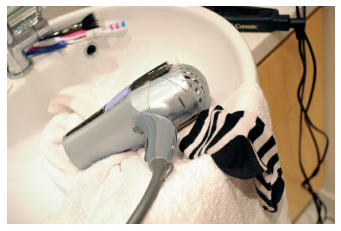

In [60]:
for image in image_ds.take(1):
    plt.imshow((image + 1) / 2)
    plt.axis("off")
    plt.show()

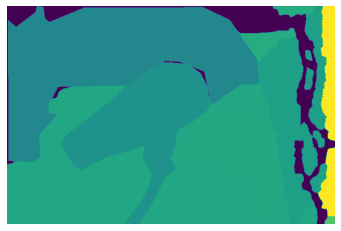

In [61]:
for segmentation in annotation_ds.take(1):
    plt.imshow((segmentation + 1) / 2)
    plt.axis("off")
    plt.show()

### Pipeline utilities

In [62]:
def random_crop(size=(256, 256)):
    def __pp(segmentation_map, image):
        crop_size = tf.convert_to_tensor(size)

        image_shape = tf.shape(image)[:2]
        margins = image_shape - crop_size

        y1 = tf.random.uniform(shape=(), maxval=margins[0], dtype=tf.int32)
        x1 = tf.random.uniform(shape=(), maxval=margins[1], dtype=tf.int32)
        y2 = y1 + crop_size[0]
        x2 = x1 + crop_size[1]

        labels = tf.identity(segmentation_map)
        labels = ((labels + 1) / 2) * 255.0
        labels = tf.cast(labels, tf.uint8)

        cropped_images = []
        images = [segmentation_map, image, labels]
        for img in images:
            cropped_images.append(img[y1:y2, x1:x2])
        return cropped_images

    return __pp


def standard_resize(image_size=(256, 256)):
    def __pp(segmentation_map, image):
        segmentation_map.set_shape([None, None])
        image.set_shape([None, None, 3])

        segmentation_map = tf.image.resize(segmentation_map[..., None], image_size)
        image = tf.image.resize(image, image_size)

        labels = tf.identity(segmentation_map)
        labels = ((labels + 1) / 2) * 255.0
        labels = tf.cast(labels, tf.uint8)

        return tf.squeeze(segmentation_map), image, tf.squeeze(labels)

    return __pp


def one_hot_encoding(segmentation_map, image, labels):
    segmentation_map_ohe = tf.one_hot(labels, NUM_CLASSES)
    return segmentation_map, image, segmentation_map_ohe


def prepare_dataset(image_paths, annotation_paths, train=True):
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths).map(
        load_image, num_parallel_calls=AUTO
    )
    annotation_ds = tf.data.Dataset.from_tensor_slices(annotation_paths)
    annotation_ds = annotation_ds.map(
        lambda x: tf.numpy_function(load_annotation, [x], tf.float32),
        num_parallel_calls=AUTO,
    ).cache()

    dataset = tf.data.Dataset.zip((annotation_ds, image_ds))
    dataset = dataset.shuffle(BATCH_SIZE * 10) if train else dataset
    map_fn = random_crop() if train else standard_resize()
    dataset = dataset.map(map_fn, num_parallel_calls=AUTO)
    dataset = dataset.map(one_hot_encoding, num_parallel_calls=AUTO)

    return dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTO)

## Create datasets

In [63]:
training_set = prepare_dataset(new_train_image_paths, new_train_anno_paths)
validation_set = prepare_dataset(val_image_paths, val_anno_paths, train=False)
test_set = prepare_dataset(test_image_paths, test_anno_paths, train=False)

## Preview

Segmentation map batch shape: (16, 256, 256).
Image batch shape: (16, 256, 256, 3).
One-hot encoded label map shape: (16, 256, 256, 172).


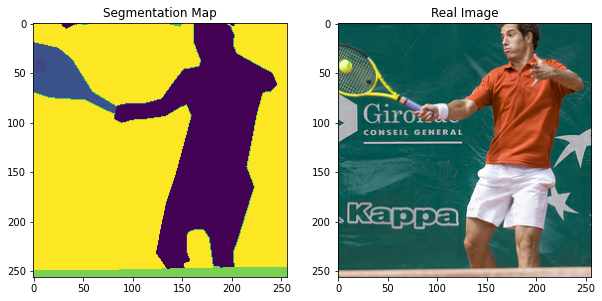

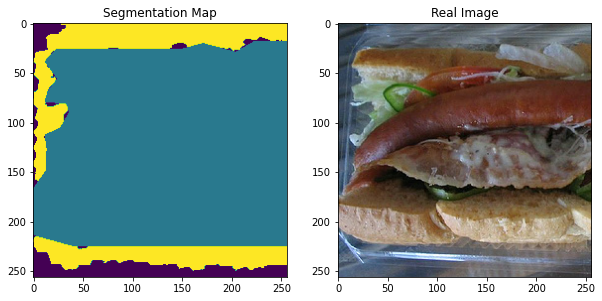

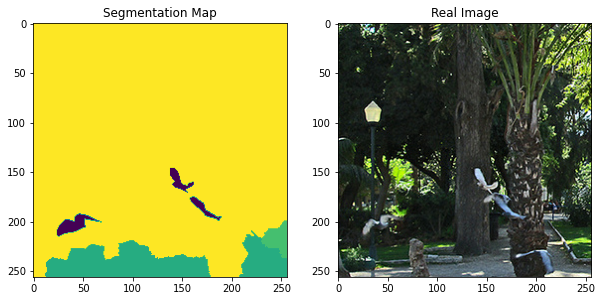

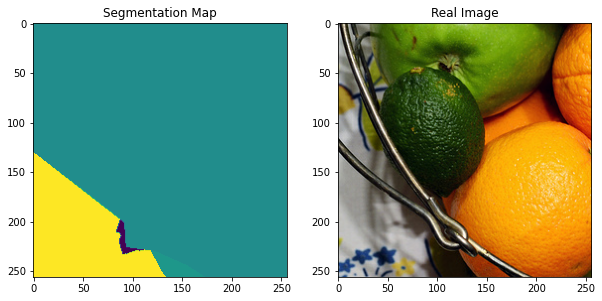

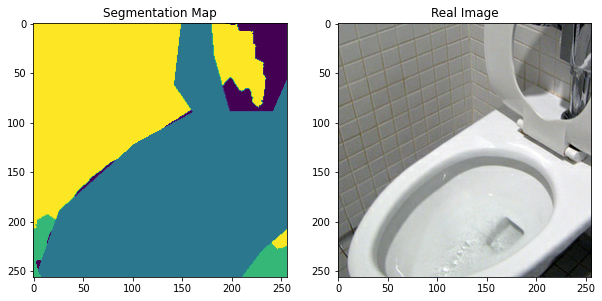

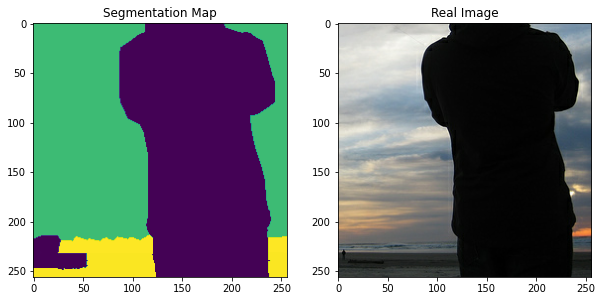

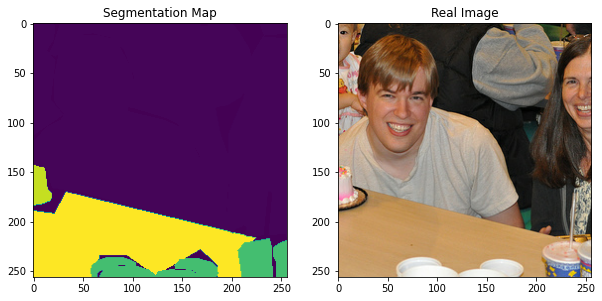

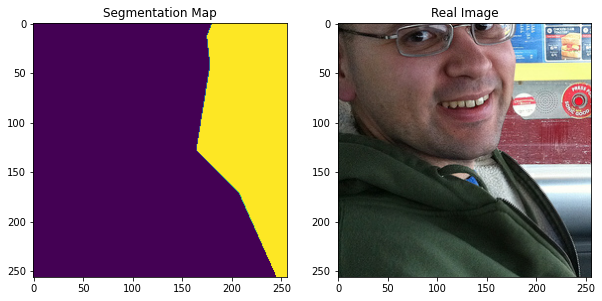

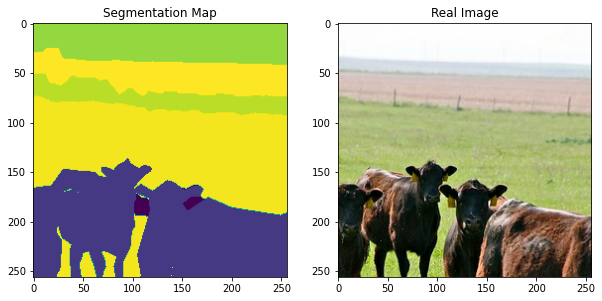

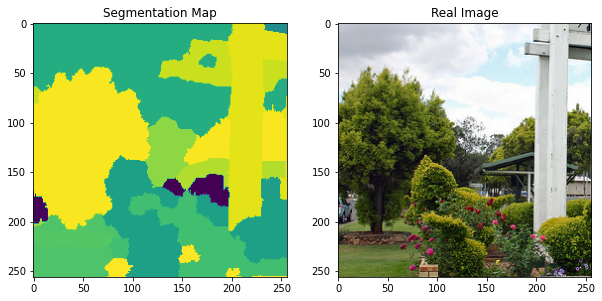

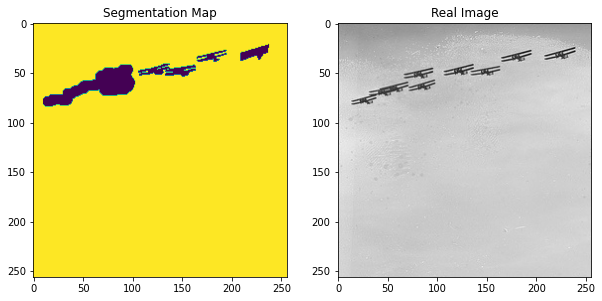

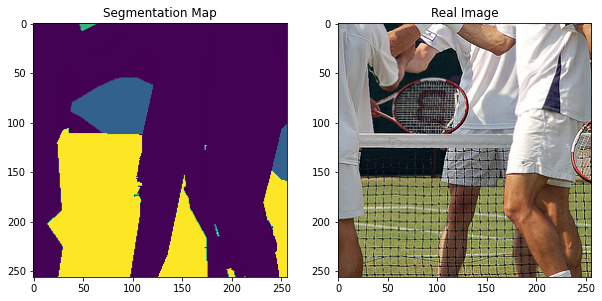

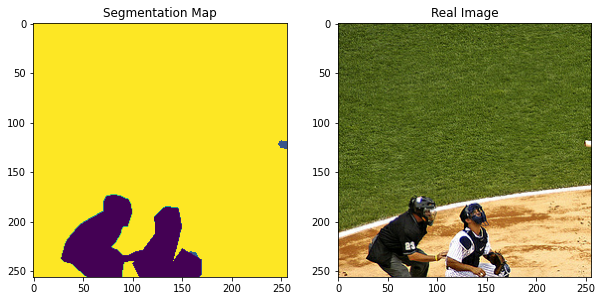

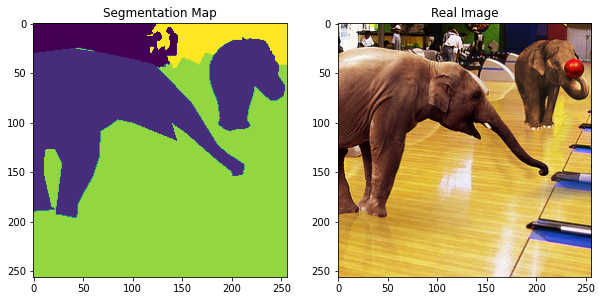

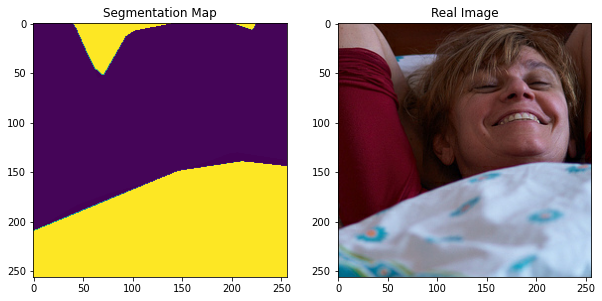

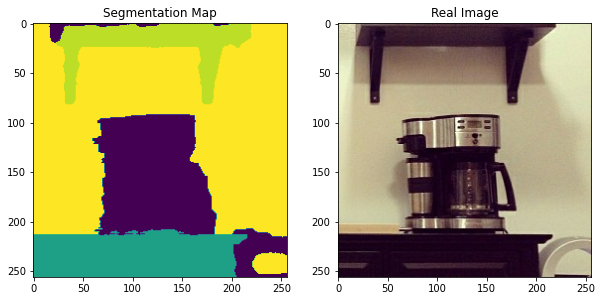

In [64]:
sample_train_batch = next(iter(training_set))
print(f"Segmentation map batch shape: {sample_train_batch[0].shape}.")
print(f"Image batch shape: {sample_train_batch[1].shape}.")
print(f"One-hot encoded label map shape: {sample_train_batch[2].shape}.")

# Plot a view samples from the training set.
for segmentation_map, real_image in zip(sample_train_batch[0], sample_train_batch[1]):
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1).set_title("Segmentation Map")
    plt.imshow((segmentation_map + 1) / 2)
    fig.add_subplot(1, 2, 2).set_title("Real Image")
    plt.imshow((real_image + 1) / 2)
    plt.show()

In [65]:
sample_validation_batch = next(iter(validation_set))
print(f"Segmentation map batch shape: {sample_validation_batch[0].shape}.")
print(f"Image batch shape: {sample_validation_batch[1].shape}.")
print(f"One-hot encoded label map shape: {sample_validation_batch[2].shape}.")

sample_test_batch = next(iter(test_set))
print(f"Segmentation map batch shape: {sample_test_batch[0].shape}.")
print(f"Image batch shape: {sample_test_batch[1].shape}.")
print(f"One-hot encoded label map shape: {sample_test_batch[2].shape}.")

Segmentation map batch shape: (16, 256, 256).
Image batch shape: (16, 256, 256, 3).
One-hot encoded label map shape: (16, 256, 256, 172).
Segmentation map batch shape: (16, 256, 256).
Image batch shape: (16, 256, 256, 3).
One-hot encoded label map shape: (16, 256, 256, 172).


<font color=red>Question</font>: Is the label one-hot encoding scheme right?